# Neural style transfer

## Setup


### Import and configure modules

In [1]:
# Batch Parameters
epochs = 10
steps_per_epoch = 200
saveStep = [1000, 2000]
content_path = '/content/gdrive/Shared drives/AI Team Docs/Version Releases/Version 0.7/Tech Note/Images bulk/'
style_path = '/content/gdrive/Shared drives/AI Team Docs/Version Releases/Version 0.7/Tech Note/Styles bulk/'
save_path = '/content/gdrive/Shared drives/AI Team Docs/Version Releases/Version 0.7/Tech Note/Style Transferred Images/Arch 6/'

content_layers = ['block5_conv2']
style_layers = ['block1_conv1']

style_weight=2
content_weight=1

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/NFT_Test/

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/content/gdrive/MyDrive/NFT_Test/'
/content


In [3]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [4]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [5]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [8]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [9]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [10]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [11]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

To optimize this, use a weighted combination of the two losses to get the total loss:

In [12]:
def style_content_loss(outputs,style_targets,style_weight,num_style_layers,content_targets,content_weight,num_content_layers):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [13]:
def changeImage(content_image,style_image,content_layers,style_layers):

  num_content_layers = len(content_layers)
  num_style_layers = len(style_layers)

  style_extractor = vgg_layers(style_layers)
  style_outputs = style_extractor(style_image*255)

  extractor = StyleContentModel(style_layers, content_layers)

  results = extractor(tf.constant(content_image))
  
  style_targets = extractor(style_image)['style']
  content_targets = extractor(content_image)['content']

  image = tf.Variable(content_image)
  return extractor, style_targets,content_targets,image,num_style_layers,num_content_layers

Now run a few steps to test:

Since it's working, perform a longer optimization:

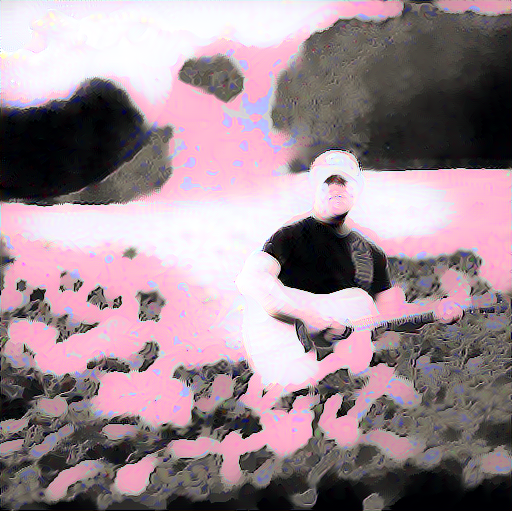

Train step: 2000
Total time: 305.3


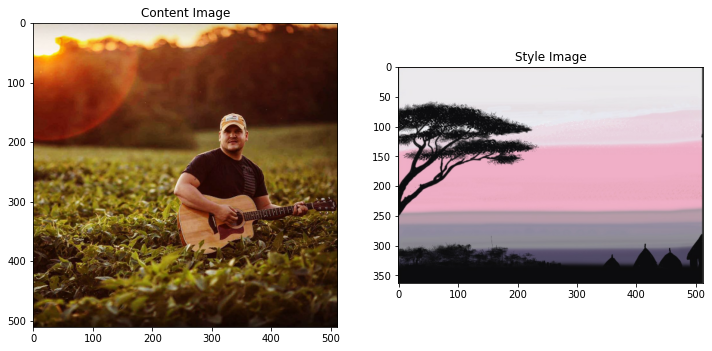

In [14]:
import time
import os
import glob

content_images = glob.glob(content_path + '/*')
style_images = glob.glob(style_path + '/*')
# for content_name in content_names:

start = time.time()

for contentImage in content_images:
  for styleImage in style_images:
    file_name = save_path+contentImage.split('/')[-1][:-4]+'_'+styleImage.split('/')[-1][:-4]
    step = 0
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    content_image = load_img(contentImage)
    style_image = load_img(styleImage)

    plt.subplot(1, 2, 1)
    imshow(content_image, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style_image, 'Style Image')
    plt.savefig(file_name+'_comparision.png')
    
    extractor,style_targets,content_targets,image,num_style_layers,num_content_layers = changeImage(content_image,style_image,content_layers,style_layers)

    @tf.function()
    def train_step(image,extractor,opt,style_targets,style_weight,num_style_layers,content_targets,content_weight,num_content_layers):
      with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs,style_targets,style_weight,num_style_layers,content_targets,content_weight,num_content_layers)

      grad = tape.gradient(loss, image)
      opt.apply_gradients([(grad, image)])
      image.assign(clip_0_1(image))

    train_step(image,extractor,opt,style_targets,style_weight,num_style_layers,content_targets,content_weight,num_content_layers)
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        train_step(image,extractor,opt,style_targets,style_weight,num_style_layers,content_targets,content_weight,num_content_layers)
        print(".", end='', flush=True)
        if step in saveStep:
          tensor_to_image(image).save(file_name+'_'+str(step)+'.png')
      display.clear_output(wait=True)
      display.display(tensor_to_image(image))
      print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))